# Introduction

Modern AI applications in urban planning, environmental monitoring, and disaster response rely on precise analysis of <b>georeferenced imagery</b>—high-resolution drone or satellite data embedded with spatial metadata. This module focuses on preparing such imagery for <b>semantic segmentation</b>, a technique critical for tasks like identifying buildings, land cover, or infrastructure in aerial datasets.

Semantic segmentation is the process of classifying every pixel in an image into a predefined category (e.g., "building," "vegetation," or "road"). For georeferenced imagery, this technique transforms raw drone or satellite data into detailed, actionable maps. Unlike object detection (bounding boxes) or classification (whole-image labels), segmentation provides fine-grained spatial understanding—critical for mapping infrastructure, tracking land use, or monitoring environmental changes.

<figure style="text-align: center">
  <img src="https://www.researchgate.net/publication/336934637/figure/fig4/AS:1141320089387015@1649123322409/Recognition-problems-related-to-generic-object-detection-a-image-level-object.png" width=400>
  <figcaption><i>Illustration of different computer vision use cases<br>
  Taken from: <a href="https://www.researchgate.net/publication/336934637_Deep_Learning_for_Generic_Object_Detection_A_Survey">researchgate.net</a></i></figcaption>
</figure>

<figure style="text-align: center">
  <img src="https://pub.mdpi-res.com/remotesensing/remotesensing-13-02450/article_deploy/html/images/remotesensing-13-02450-g002.png?1624441623" width=400>
  <figcaption><i>Illustration of different computer vision use cases in georeferenced imagery<br>
  Taken from: <a href="https://www.mdpi.com/2072-4292/13/13/2450">mdpi.com</a></i></figcaption>
</figure>

<b>You’ll learn to</b> collect, preprocess, and augment geospatial data, convert vector labels into raster masks, and build scalable data pipelines compatible with deep learning frameworks. By working with real-world datasets and APIs, you’ll bridge raw imagery to trainable models, mastering skills essential for deploying AI solutions in geospatial contexts.

Key elements covered:
- Georeferenced data handling (coordinate systems, alignment)
- Programmatic data preparation (APIs, automation)

# Task 1: Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
%%capture
# Install required Python packages:
# - rioxarray: for reading and writing geospatial raster data
# - boto3: AWS SDK for Python, used to interact with S3 buckets
!pip install rioxarray boto3 geopandas

## Importing Libraries

In [4]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr

import boto3

pd.set_option('display.max_columns', None)

## Preparing Directories

In [ ]:
NB_DIR = Path("..")
PROJECT_DIR = NB_DIR

DATA_DIR = PROJECT_DIR / 'data'
RAW_DATA_DIR = DATA_DIR / '0_raw'
INTERIM_DATA_DIR = DATA_DIR / '1_interim'
PATCH_DIR = DATA_DIR / '2_patches'

folder_list = [
    DATA_DIR,
    RAW_DATA_DIR,
    INTERIM_DATA_DIR,
    PATCH_DIR,
]

for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

RANDOM_SEED = 42

# Task 2: Data Collection and Preparation

To start with the project, we first need to collect the data. In this project, we are going to fetch both the image and the label. In real-world project, depending on how the team operate, sometimes the task of annotating the image is also the responsibility of the data scientist. However, in this case, we are going to assume that there are other role that responsible for the annotation, so we can focus on developing the model.

## Georeferenced Imagery

<figure style="text-align: center">
  <img src="https://www.earthdatascience.org/images/earth-analytics/raster-data/raster-concept.png" width=500>
  <figcaption><i>A raster is composed of a regular grid of cells. Each cell is the same size in the x and y direction. Source: Colin Williams, NEON.<br>
  Taken from: <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/">earthdatascience.org</a></i></figcaption>
</figure>

Georeferenced imagery is special since every pixel represents certain location on our earth, that is why not every annotating tools can be used to annotate georeferenced imagery. One open source tools that can handle this gracefully is called [QGIS](https://qgis.org).

<figure style="text-align: center">
  <img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEigG5troRMTI2UmSw9HyvICWtC3KLRtE-7w-CgiF4HVw9kNZ2Ahb6LWYQDPq6Ehx5_86SNSmL3sTRXOG07aQTAOU6lf5m6jjgaiSLqod6KcsJwWLZ2q44BZ-uiH0Hrk5-lys_YAk_tiBhSNtDWvNzBoJXHUT6dNoklpwrkIN5CUoX2lIOBKpI8U85BmKA/s708/digitizing%20building.gif" width=400>
  <figcaption><i>Digitizing/annotating georeferenced imagery in QGIS.<br>Taken from: <a href="https://www.geodose.com/2022/08/qgis-tips-tricks-how-digitize-perfect-building-footprint.html">geodose.com</a></i></figcaption>
</figure>

## Exploring The Data Source

This project will use https://source.coop as its data source.

> Source Cooperative is a data publishing utility that allows trusted organizations and individuals to share data using standard HTTP methods.
A core belief behind Source is that it should be much easier for people and organizations to share data on the open web.

To browse and access data from https://source.coop, we can use [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html), [AWS SDK for Python (Boto3)](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), and just recently, an [Unofficial Source Coop Python SDK & CLI](https://source.geocarpentry.org) was published.

<b>Note</b><br>
If you are using google colab, you have to install awscli first
```
!pip install aws configure
!pip install awscli
```

If you are running the notebook locally, please follow the guidance for [AWS CLI Installation](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html)

`data.source.coop` is publicly accessible, you might be able to use anonymous access by setting dummy credentials

In [6]:
%%capture
!pip install aws configure
!pip install awscli

In [7]:
!aws configure set aws_access_key_id "fakekey"
!aws configure set aws_secret_access_key "fakesecret"

In [8]:
!aws s3 ls s3://open-cities/ai-challenge/ --endpoint-url=https://data.source.coop

                           PRE .source/
                           PRE test/
                           PRE train_tier_1/
                           PRE train_tier_2/
2023-04-03 19:41:07       1768 README.md
2021-08-26 22:21:57    1919684 documentation.pdf


In the script above, we use:
- `!` to the jupyter notebook we want to run a command inside a command prompt
- Then we wrote `aws` to indicate that we are going to use aws command
- In AWS CLI, we use `ls` to list the files and directory inside an s3 bucket
- `s3://open-cities/ai-challenge/` is the path of the bucket that we want to explore
- lastly we add an endpoint url `--endpoint-url=https://data.source.coop`

<div class="alert alert-block alert-success">
<h3>Excercise 1</h3>
Explore the data using awscli
</div>

Modify the aws cli command below to find your way into any `.tif` file inside the bucket<br>

`!aws s3 ls s3://open-cities/ai-challenge/ --endpoint-url=https://data.source.coop`

<details>
<summary>Click to see answer.</summary>

Sample answer:<br>
Create a new cell in the jupyter notebook and run this script<br>
```bash
!aws s3 ls s3://open-cities/ai-challenge/test/903bdd/ --endpoint-url=https://data.source.coop
```

Any path is an acceptable answer as long as it shows a `.tif` file in the result
</details>

### Exploring the bucket/data repository

To make it more python-native, let's explore the data repository using boto3. The script below will list all items inside `ai-challange/train_tier_1/`.

<b>You can change the `Prefix` to list the items inside different path</b>

In [9]:
# Configure the client to use the specific endpoint
s3 = boto3.client(
    's3',
    endpoint_url='https://data.source.coop',
    aws_access_key_id='fakekey',
    aws_secret_access_key='fakesecret'
)

bucket_name = 'open-cities'

# List objects in the bucket
response = s3.list_objects_v2(
    Bucket=bucket_name,
    Prefix='ai-challenge/train_tier_1/'
)

files_data = []

for obj in response.get('Contents', []):
    files_data.append({
        'Key': obj['Key'],
        'Size (bytes)': obj['Size'],
        'Size': f"{obj['Size']/(1024*1024):.2f} MB" if obj['Size'] >= 1024*1024 else
                f"{obj['Size']/1024:.2f} KB" if obj['Size'] >= 1024 else
                f"{obj['Size']} B",
        'Last Modified': obj['LastModified']
    })

In [10]:
if files_data:
    df = pd.DataFrame(files_data)
    print(f"Found {len(df)} files")
    display(df)
else:
    print("No files found")

Found 160 files


,Key,Size (bytes),Size,Last Modified
0,ai-challenge/train_tier_1/acc/665946-labels/66...,7955,7.77 KB,2021-08-26 20:28:50+00:00
1,ai-challenge/train_tier_1/acc/665946-labels/66...,10902820,10.40 MB,2021-08-26 20:34:37+00:00
2,ai-challenge/train_tier_1/acc/665946/665946.json,7501,7.33 KB,2021-08-26 20:34:06+00:00
3,ai-challenge/train_tier_1/acc/665946/665946.tif,3616008155,3448.49 MB,2021-08-26 20:34:27+00:00
4,ai-challenge/train_tier_1/acc/665946/665946.ti...,1168,1.14 KB,2021-08-26 20:33:13+00:00
...,...,...,...,...
155,ai-challenge/train_tier_1/znz/e52478-labels/e5...,2201,2.15 KB,2021-08-26 20:29:23+00:00
156,ai-challenge/train_tier_1/znz/e52478-labels/e5...,10625,10.38 KB,2021-08-26 20:30:12+00:00
157,ai-challenge/train_tier_1/znz/e52478/e52478.json,1748,1.71 KB,2021-08-26 20:34:15+00:00
158,ai-challenge/train_tier_1/znz/e52478/e52478.tif,431621975,411.63 MB,2021-08-26 20:29:10+00:00


<div class="alert alert-block alert-success">
<h3>Excercise 2</h3>
Explore the listed data
</div>

Answer these question:
1. What is the largest file size listed in the `DataFrame`?
1. What is the smallest file size listed in the `DataFrame`?

<details>
<summary>Click to see answer.</summary>

Sample answer:<br>
Create a new cell in the notebook and run this script<br>
```python
largest_key = df.sort_values('Size (bytes)').Key.tail(1).values[0]
largest_size = df.sort_values('Size (bytes)').Size.tail(1).values[0]
smallest_key = df.sort_values('Size (bytes)').Key.head(1).values[0]
smallest_size = df.sort_values('Size (bytes)').Size.head(1).values[0]

print(
f"""Largest item is: {largest_key} with size of {largest_size}
Smallest item is: {smallest_key} with size of {smallest_size}""")
```
</details>

Let's continue the exploration

In [11]:
# Extract extensions from the Key column
df['Extension'] = df['Key'].apply(lambda x: x.split('.')[-1] if '.' in x else 'no_extension')

# Get unique extensions and their counts
extension_counts = df['Extension'].value_counts()

# Print unique extensions
print("Unique file extensions:")
for ext, count in extension_counts.items():
    print(f".{ext}: {count} files")

Unique file extensions:
.json: 70 files
.geojson: 31 files
.tif: 31 files
.xml: 28 files


Looking at the result above, we can see there are 4 different file format. What's important for our project are `.tif` and `.geojson` files.

- The `.tif` files are the image. It is common to see georeferenced image in this format. Visually they are the same as `.jpg` file.
- The `.geojson` files are the label/annotation. As you may suspect, the format is very similar with normal `.json` files, but `.geojson` store some relevant geospatial information, such as the coordinate reference system (CRS).

## Fetching The Data

We will use data from area coded `mon` with item id of `493701`.<br>
Feel free to use a different area and item id to fetch a pair of image and label.

In [12]:
# Set bucket and object key
area_name = 'mon'
item_id = '493701'
image_format = 'tif'
label_format = 'geojson'
image_key = f'ai-challenge/train_tier_1/{area_name}/{item_id}/{item_id}.{image_format}'
label_key = f'ai-challenge/train_tier_1/{area_name}/{item_id}-labels/{item_id}.{label_format}'

for my_object, format in zip([image_key, label_key], [image_format, label_format]):
    dest_path = f'{RAW_DATA_DIR}/{item_id}.{format}'
    if not Path(dest_path).exists():
        try:
            print(f"Downloading {item_id}.{format}...")
            response = s3.get_object(Bucket=bucket_name, Key=my_object)
            file_content = response['Body'].read()
            with open(f'{RAW_DATA_DIR}/{item_id}.{format}', 'wb') as f:
                f.write(file_content)
            print("File downloaded")
        except Exception as e:
            print(f"Error downloading file: {e}")
    else:
        print(f"{dest_path} already exist, skipping download...")

data/0_raw/493701.tif already exist, skipping download...
data/0_raw/493701.geojson already exist, skipping download...


In [13]:
# Open image with rioxarray
rds = rxr.open_rasterio(
    str(RAW_DATA_DIR/f'{item_id}.{image_format}'),
    driver='GTiff'
)

# Open label with geopandas
label_gdf = gpd.read_file(str(RAW_DATA_DIR/f'{item_id}.{label_format}'))

In [14]:
rds

<xarray.DataArray (band: 4, y: 21783, x: 22333)> Size: 2GB
[1945918956 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 179kB 3.02e+05 3.02e+05 ... 3.03e+05 3.03e+05
  * y            (y) float64 174kB 7.005e+05 7.005e+05 ... 6.996e+05 6.996e+05
    spatial_ref  int64 8B 0
Attributes: (12/13)
    TIFFTAG_SOFTWARE:  APS - Menci Software - www.menci.com
    TIFFTAG_DATETIME:  25-08-2018 09:57:12
    LL_LAT:            6.32629460897868
    LL_LON:            -10.79217504000558
    LR_LAT:            6.326332202763627
    LR_LON:            -10.78124386562269
    ...                ...
    UL_LON:            -10.792204876798666
    UR_LAT:            6.334984563027563
    UR_LON:            -10.781273520664838
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0

In [15]:
label_gdf.head(2)

,building,scene_id,scene_area,addr:city,addr:community,building:levels,building:material,min_height,roof:material,source,building:roof,comment,name,religion,addr:street,amenity,shop,abandoned,layer,access,fee,operator,toilets:disposal,toilets:handwashing,bed_count,dispensing,emergency,opening_hours,operator_name,drinking_water,man_made,operational_status,pump,geometry
0,yes,5b83a514c8e197000a93403f,mon,Monrovia,Doe Community,1,cement_block,0.38,None,Open Cities Monrovia - HOT Field Survey,metal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-10.78665 6.33194, -10.78657 6.3319,..."
1,yes,5b83a514c8e197000a93403f,mon,Monrovia,Doe Community,1,cement_block,None,None,Open Cities Monrovia - HOT Field Survey,metal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-10.7871 6.33061, -10.78701 6.33056,..."


In [16]:
print(rds.rio.crs)
print(label_gdf.crs)

EPSG:32629
EPSG:4326


Notice that the ID of the CRS for the image and the label are different.
- The image CRS is in `EPSG: 32629`
- The label CRS in in `EPSG: 4326`

<figure style="text-align: center">
  <img src="https://www.esri.com/arcgis-blog/wp-content/uploads/2022/02/grid2.png" width=400>
  <figcaption><i>Illustration of the same point being represented in different coordiate reference systems (CRS).<br>
  Taken from: <a href="https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs">esri.com</a></i></figcaption>
</figure>

What's tricky about spatial data is they can have a different CRS. A different CRS can lead to misalignment when we try to visualize them.
So to make sure they are aligned, we need to <u>project</u> the label's CRS into the image's CRS before visualizing them.

In [17]:
if label_gdf.crs != rds.rio.crs:
    plot_gdf = label_gdf.to_crs(rds.rio.crs)
else:
    plot_gdf = label_gdf

## Visualize The Image

In [18]:
%%capture
!pip install earthpy

In [19]:
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
import earthpy.plot as ep

/home/akm/Work/virt-env/general/lib/python3.12/site-packages/earthpy/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


Visualizing the image and the label
It may take a while...


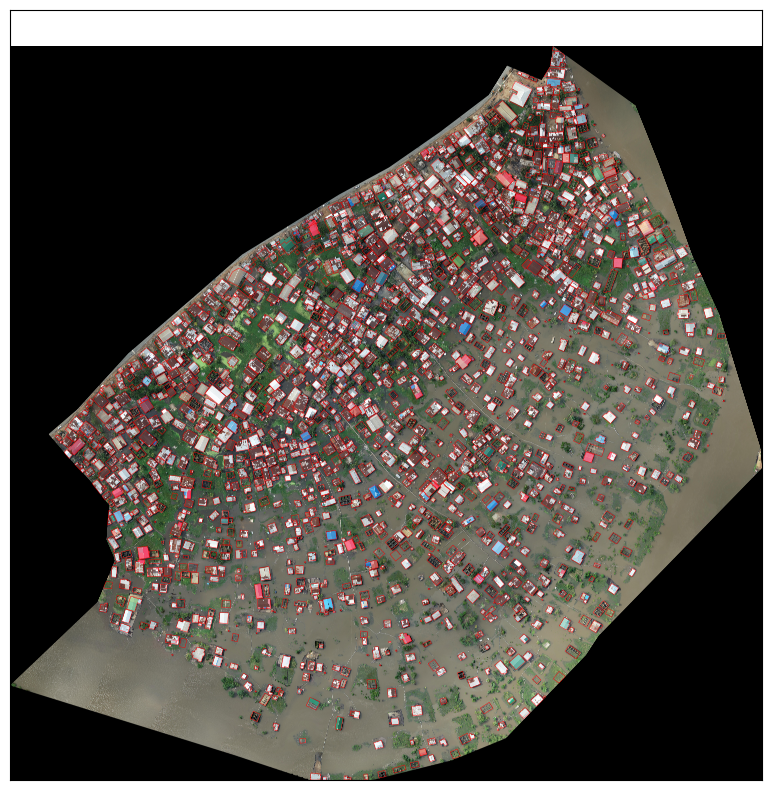

In [20]:
print("Visualizing the image and the label")
print("It may take a while...")
fig, ax = plt.subplots(figsize=(10,10))

plot_extent = plotting_extent(
    rds[0],
    rds.rio.transform()
)

ep.plot_rgb(
    rds.values,
    rgb=[0, 1, 2],
    ax=ax,
    extent=plot_extent
)

plot_gdf.boundary.plot(ax=ax, linewidth=0.3, color='red')

plt.show()

<div class="alert alert-block alert-success">
<h3>Excercise 3</h3>
Explore the label
</div>

How many building detected in the image above?

<details>
<summary>Click to see answer.</summary>

Sample answer:<br>
Create a new cell in the jupyter notebook and run this script<br>
```python
print(f"There are {len(label_gdf)} buildings detected!")
```
</details>

# Task 3: Data Preparation

## Convert to RGB
If you notice, our `rds` contain 4 bands, this is quite common in drone imagery product, the bands are usually: <span style="color:red">red</span>, <span style="color:green">green</span>, <span style="color:blue">blue</span>, and alpha (or sometimes near-infrared). In that order.

For our model later, we will only need 3 bands, RGB. So first, we need to extract the image as RGB image.

In [21]:
rgb_data = rds.isel(band=[0, 1, 2])  # Select R, G, B bands

rgb_img_path = INTERIM_DATA_DIR/f'{item_id}_rgb.{image_format}'

if not rgb_img_path.exists():
    # Export as a 3-band GeoTIFF
    print(f"Saving rasterized label to {rgb_img_path}")
    rgb_data.rio.to_raster(
        str(rgb_img_path),
        driver='GTiff',
        compress='lzw'
    )
else:
    print(f"{rgb_img_path} already exists, skipping the process")

data/1_interim/493701_rgb.tif already exists, skipping the process


## Rasterize Label

Our label is in <b>vector</b> format while our deep learning process later will need it in <b>raster</b> format.<br>
So, let's turn our label from vector to raster.

In [22]:
from rasterio.features import rasterize, geometry_mask

In [23]:
path_exp_target = INTERIM_DATA_DIR / f"{item_id}_mask.{image_format}"
# exporting clipped label as mask
if not path_exp_target.exists():
    with rio.open(RAW_DATA_DIR / f'{item_id}.{image_format}') as src:
        sample_label = label_gdf.to_crs(src.crs)
        geometry = sample_label.geometry

        # Create a mask using the geometry and raster's shape
        mask = geometry_mask(geometry, out_shape=src.shape, transform=src.transform, invert=True)

        # Assign a specified label value to the areas within the shapefile
        label_value = (255, 255, 255)  # RGB value for the label
        mask_rgb = np.zeros((src.height, src.width, 3), dtype=np.uint8)
        mask_rgb[mask] = label_value

        # Transpose the mask_rgb array
        mask_rgb = np.transpose(mask_rgb, (2, 0, 1))

    # Save the mask as a raster
    print(f"Saving rasterized label to {path_exp_target}")
    with rio.open(
        path_exp_target, 'w', driver='GTiff', width=src.width, height=src.height,
        count=3, crs=src.crs, transform=src.transform, dtype=rio.uint8, compress='lzw'
        ) as dst:
        dst.write(mask_rgb)
else:
    print(f"{path_exp_target} already exists, skipping the process")

data/1_interim/493701_mask.tif already exists, skipping the process


## Patchify Training Data

Another thing that make georeferenced imagery special is that it is usually relatively big in size (`mon/493701` is around 230 mb) and normally we only have one image (or a few).
This lead to a problem if we want to develop a deep learning model.
1. Deep learning usually require quite a lot of training sample, one sample is definitely not enough.
1. Even if we try to train the deep learning model, it will be very tricky to fit an image that huge into memory (especially for training).

That is why, we need to make an additional step to turn our one image, into <b>patches</b>.

In [24]:
# On linux, you may need to install GDAL system packages
!apt-get install -y gdal-bin libgdal-dev

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [25]:
%%capture
!pip install GeoPatch==1.1.1

In [26]:
from GeoPatch import TrainPatch

In [27]:
# setup patch size and stride length
patch_size = 512
stride_dist = patch_size

# prepare raster and mask path
image_path = INTERIM_DATA_DIR /  f"{item_id}_rgb.{image_format}"
mask_path = INTERIM_DATA_DIR / f"{item_id}_mask.{image_format}"

patch = TrainPatch(
    image=str(image_path), label=str(mask_path),
    patch_size=patch_size, stride=stride_dist, channel_first=True
)

# Displaying shape and size of input image
patch.data_dimension()

# Displaying the number of orginal image patches
patch.patch_info()

# save patches
patch.save_Geotif(str(PATCH_DIR), only_label=True)

############################################
 the shape of image is: (3, 21783, 22333) 
 the shape of label is: (21783, 22333) 
############################################
       
#######################################################################################
The effective X-dimension of the input data for patch generation is from 0 to 21504
The effective Y-dimension of the input data for patch generation is from 0 to 22016
The number of total non-augmented patches that can be generated
based on patch size (512*512) and stride (512) is "1722"
#######################################################################################
                                                                        


Patch Counter:  57%|█████▋    | 989/1722 [00:07<00:05, 125.98 Patch/s]

#######################################################################################
989 patches, which are %57 of totall patches, are saved as ".tif" format in "/home/akm/Work/Compu/Drone-Image-DL-Classification/nb\data/2_patches"
#######################################################################################


In [28]:
from glob import glob

label_list = glob(str(PATCH_DIR/"label/*.tif"))
patch_list = glob(str(PATCH_DIR/"patch/*.tif"))

print(f"Found {len(label_list)} label")
print(f"Found {len(patch_list)} patch")

Found 989 label
Found 989 patch


<div class="alert alert-block alert-success">
<h3>Excercise 4</h3>
Count of patch
</div>

You may notice during the process, the number of total non-augmented patches doesn't match the number of total image generated.<br>
Why do you think is that?

<details>
<summary>Click to see answer.</summary>
Look at the image visualized on the previous section. You may notice, not every area are covered by the label.
When we save the patch, we pass `True` for the `only_label` parameter. This ensure only images that overlap with the label extracted as our patch. Some of the area that is not covered by any label wont be extracted, hence the difference.
</details>

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset

import albumentations as A

from random import randint

## Create Custom Dataset

<div class="alert alert-block alert-info">
A custom dataset structures raw data for your AI task. For building segmentation with drone imagery, our <code>BuildingsDroneDataset</code> handles:

<strong>Key Components:</strong>
- <b>Paired Geospatial Data:</b> Loads aligned TIF patches (drone imagery) and masks (building labels) from directories
- <b>Data Integrity:</b> Automatically verifies patch-label count matches to prevent training errors
- <b>Augmentation Pipeline:</b> Applies spatial/color transforms to both images <i>and</i> masks simultaneously using Albumentations
- <b>Geospatial Processing:</b> Maintains rasterio-compatible TIF handling while converting to PyTorch tensors
- <b>Visual QA:</b> Built-in <code>plot_pair()</code> method to inspect image-mask alignment

Like teaching a model to "see" buildings, this dataset ensures pixel-aligned pairs of aerial scans and their ground truths - whether analyzing urban expansion or disaster-damaged structures.
</div>

In [30]:
# Define BuildingsDroneDataset class
class BuildingsDroneDataset(Dataset):
    """Dataset for building segmentation from drone imagery.

    Args:
        patch_dir (str): path to patch images folder (TIF format)
        label_dir (str): path to label masks folder (TIF format)
        augmentation (albumentations.Compose): data transformation pipeline
        preprocessing (albumentations.Compose): data preprocessing
    """

    def __init__(
        self,
        patch_dir,
        label_dir,
        augmentation=None,
        preprocessing=None,
    ):
        # Get paths to all TIF files in the directories
        self.patch_paths = [os.path.join(patch_dir, file_name)
                          for file_name in sorted(os.listdir(patch_dir))
                          if file_name.endswith('.tif')]

        self.label_paths = [os.path.join(label_dir, file_name)
                           for file_name in sorted(os.listdir(label_dir))
                           if file_name.endswith('.tif')]

        # Verify that we have matching number of patches and labels
        assert len(self.patch_paths) == len(self.label_paths), \
            f"Number of patches ({len(self.patch_paths)}) and labels ({len(self.label_paths)}) don't match"

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Read TIF images using rasterio
        with rio.open(self.patch_paths[i]) as patch_file:
            # Read all bands and transpose to (channels, height, width)
            patch = patch_file.read()
            # Convert to (height, width, channels) for albumentations
            patch = np.transpose(patch, (1, 2, 0))

        with rio.open(self.label_paths[i]) as label_file:
            # Assume mask is single channel
            mask = label_file.read(1)

        # Ensure mask has values 0 and 1 only
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=patch, mask=mask)
            patch, mask = sample['image'], sample['mask']

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=patch, mask=mask)
            patch, mask = sample['image'], sample['mask']

        # Convert numpy arrays to PyTorch tensors
        patch = torch.from_numpy(patch)
        mask = torch.from_numpy(mask)

        return patch, mask

    def __len__(self):
        return len(self.patch_paths)

    def plot_pair(self, idx=None):
        if idx is not None:
            idx = idx
        else:
            idx = randint(0, len(self)-1)
        _, ax = plt.subplots(1, 2, figsize=(8, 4))

        img, mask = self[idx]

        # Convert tensors back to numpy for plotting
        img = img.numpy()
        mask = mask.numpy()

        # Handle different dimensions based on preprocessing
        if len(img.shape) == 3 and img.shape[0] == 3:  # CHW format
            img = np.transpose(img, (1, 2, 0))  # Convert to HWC for plotting

        ax[0].imshow(img)
        ax[0].set_title("Drone Image")

        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title("Building Mask")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        plt.suptitle(f"Sample {idx}")
        plt.tight_layout()


## Augmentation and Preprocessing

<div class="alert alert-block alert-info">

<u>Data Augmentation (Training Only):</u>
- <b>Spatial Transforms:</b> Random 90° rotations/flips (preserves geospatial alignment)
- <b>Drone-specific Strategy:</b> Mimics real-world variations (different flight angles, orientations)
- <b>Mask Preservation:</b> Applied simultaneously to images <i>and</i> masks via Albumentations

<u>Essential Preprocessing:</u>
- <b>Normalization:</b> Scales pixel values to [0,1] range (<code>to_float_and_normalize</code>)
- <b>Channel Formatting:</b> Converts HWC → CHW for PyTorch compatibility (<code>transpose_to_chw</code>)
- <b>Mask Safety:</b> Explicit float32 conversion prevents dtype issues in loss calculations

</div>

In [31]:
# Define augmentation and preprocessing functions
def get_training_augmentation():
    """
    Simple augmentation pipeline for drone imagery training data
    """
    train_transform = [
        # Basic spatial augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
    return A.Compose(train_transform)

def get_preprocessing():
    """
    Simple preprocessing function for drone imagery

    Returns:
        Preprocessing transform for normalization and channel reordering
    """
    # Define regular functions instead of lambdas
    def to_float_and_normalize(image, **kwargs):
        return image.astype(np.float32) / 255.0

    def transpose_to_chw(image, **kwargs):
        return image.transpose(2, 0, 1)

    def to_float32(mask, **kwargs):
        return mask.astype(np.float32)

    _transform = [
        # Scale to [0,1] range
        A.Lambda(image=to_float_and_normalize),
        # Convert to PyTorch format (CHW)
        A.Lambda(image=transpose_to_chw),
        # Ensure mask is float32
        A.Lambda(mask=to_float32),
    ]
    return A.Compose(_transform)

In [32]:
# Create dataset with augmentation and preprocessing
dataset = BuildingsDroneDataset(
    patch_dir=PATCH_DIR/'patch',
    label_dir=PATCH_DIR/'label',
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing()
)


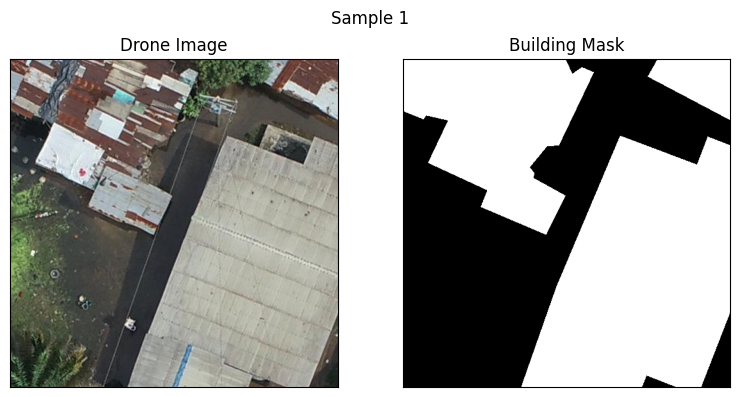

In [33]:
# Visualize a sample image and mask
sample_idx = 1 # Change this to see different samples
dataset.plot_pair(sample_idx)

## Data Split

Next, we want to split the data into training and validation.

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Split dataset into training and validation (80/20 split)
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42
)

In [36]:
# Create subset datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)} (80%)")
print(f"Validation set size: {len(val_dataset)} (20%)")

Total dataset size: 989
Training set size: 791 (80%)
Validation set size: 198 (20%)


## Turn loaded images into DataLoader
Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

In [37]:
# Create DataLoaders for training
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

In [38]:
# Example of iterating through the DataLoader
for i, (images, masks) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image shape: {images.shape}")
    print(f"  Mask shape: {masks.shape}")

    # Just process a few batches for demonstration
    if i >= 2:
        break

Batch 0:
  Image shape: torch.Size([8, 3, 512, 512])
  Mask shape: torch.Size([8, 512, 512])
Batch 1:
  Image shape: torch.Size([8, 3, 512, 512])
  Mask shape: torch.Size([8, 512, 512])
Batch 2:
  Image shape: torch.Size([8, 3, 512, 512])
  Mask shape: torch.Size([8, 512, 512])


# 🎉 Congratulations on Completing the Module! 🎉

Well done! You’ve mastered the critical steps of collecting, preprocessing, and preparing drone imagery for deep learning. Now, let’s solidify your skills with a practical task that mirrors real-world scenarios.

Here's a summary of what we did in this module
1. **Data Collection & Preprocessing**  
   - Download the dataset.
   - Convert vector labels into raster masks.
   - Handle geospatial metadata (e.g., coordinate systems, image alignment).
1. **Dataset Creation**
   - Created a dataset that compatible with PyTorch model.
1. **Augmentation & Analysis**  
   - Implement aerial-specific augmentations (e.g., rotation, flips, brightness/contrast adjustments for varying lighting conditions).  
   - Visualize samples to verify label-mask alignment post-augmentation.

# 🚀 Module Task: Prepare a New Dataset for Building Segmentation

## Task
Using a different dataset (see below for alternatives), replicate and adapt the pipeline you built in this module. Feel free to use any dataset if you have one.


## Alternative datasets
1. The [Landcover.ai Dataset](https://landcover.ai.linuxpolska.com) (aerial imagery for land cover segmentation)
1. [SpaceNet 3: Road Network Detection](https://spacenet.ai/spacenet-roads-dataset/)
1. [DOTA: A Large-scale Dataset for Object Detection in Aerial Images](https://ieee-dataport.org/documents/dota)
1. [Sentinel-2 Cloud Cover Segmentation Dataset](https://source.coop/radiantearth/cloud-cover-detection-challenge)

**Why This Task?**  
- **Skill Reinforcement:** Deepen your understanding of geospatial data handling, a critical skill for drone-based ML.
- **Pipeline Adaptability:** Practice modifying existing code for new data sources—a common task in industry projects.

**You’re ready for this!** Mastering dataset preparation ensures you can tackle any aerial imagery project, from disaster response to environmental monitoring.

**See you in the next module!**

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination directories
src_dir = str(DATA_DIR)
dst_dir = '/content/drive/MyDrive/data'

# Copy the data directory to Google Drive
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
print(f"Copied {src_dir} to {dst_dir}")